In [5]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [6]:
from langchain_core.tools import tool
import requests

In [13]:

@tool
def get_places(city: str, query: str = "attractions") -> list:
    """
    Fetches top places (e.g., attractions, restaurants) in a city using the Foursquare Places API
    and returns them as a structured JSON list.

    Parameters:
        city (str): Name of the city (e.g., 'Kolkata')
        query (str): Type of places to search for (e.g., 'attractions', 'museums')

    Returns:
        list: A list of dictionaries, each containing:
            - name: Place name
            - categories: List of category names
            - address: Formatted address
            - phone: Telephone number if available
            - website: Website URL if available
"""
    api_key = os.getenv("FOURSQUARE_API_KEY")
    if not api_key:
        return [{"error": "Missing FOURSQUARE_API_KEY"}]

    url = "https://places-api.foursquare.com/places/search"
    headers = {
        "accept": "application/json",
        "X-Places-Api-Version": "2025-06-17",
        "authorization": api_key
    }
    params = {
        "near": city,
        "query": query,
        "limit": 10
    }

    response = requests.get(url, headers=headers, params=params)
    if response.status_code != 200:
        return [{"error": f"Foursquare API error: {response.text}"}]

    results = response.json().get("results", [])
    if not results:
        return [{"message": f"No results found for '{query}' in {city}."}]

    extracted = []
    for place in results:
        name = place.get("name", "Unknown")
        categories = [cat.get("name") for cat in place.get("categories", [])]
        address = place['location']['formatted_address']
        phone = place.get("tel", None)
        website = place.get("website", None)

        extracted.append({
            "name": name,
            "categories": categories,
            "address": address,
            "phone": phone,
            "website": website
        })

    return extracted

In [4]:
# get_places.invoke(
#     {
#         "city": "Bangalore",
#         "query": "hotels"
#     }
# )

In [7]:
from langchain_core.tools import tool
import requests
import os
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate great-circle distance between two points on Earth."""
    R = 6371  # Earth radius in kilometers
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    d_phi = math.radians(lat2 - lat1)
    d_lambda = math.radians(lon2 - lon1)
    a = math.sin(d_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(d_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

@tool
def get_hotels_by_area_and_radius(
    bbox: str,
    arrival_date: str,
    departure_date: str,
    star_rating: str = "3,4,5",
    room_qty: int = 1,
    guest_qty: int = 1,
    children_qty: int = 0,
    children_age: str = "",
    currency: str = "USD",
    order_by: str = "popularity",
    categories_filter: str = "class::1,class::2,class::3",
    language: str = "en-us",
    travel_purpose: str = "leisure",
    offset: int = 0
) -> list:
    """
    Fetch hotel listings within a bounding box and return only key fields, sorted by distance to bbox center.

    Parameters:
        - bbox (str): Bounding box in format "min_lat,max_lat,min_lng,max_lng"
        - star_rating (str): Comma-separated star classes to filter, e.g., "3,4,5"
        - arrival_date (str): Check-in date (YYYY-MM-DD)
        - departure_date (str): Check-out date (YYYY-MM-DD)
        - room_qty (int): Number of rooms
        - guest_qty (int): Number of adults
        - children_qty (int): Number of children
        - children_age (str): Comma-separated list of children ages
        - currency (str): Price currency (e.g., USD, INR)
        - order_by (str): API sort preference (not used post-filter)
        - categories_filter (str): Used internally, overridden by star_rating
        - language (str): Response language
        - travel_purpose (str): "leisure" or "business"
        - offset (int): Pagination offset

    Returns:
        - list of hotel dicts sorted by ascending distance from bbox center.
    """

    # Convert star_rating to API-compatible format
    categories_filter = ",".join([f"class::{s.strip()}" for s in star_rating.split(",")])

    # Compute bbox center
    try:
        min_lat, max_lat, min_lng, max_lng = map(float, bbox.split(","))
        center_lat = (min_lat + max_lat) / 2
        center_lng = (min_lng + max_lng) / 2
    except Exception as e:
        return [{"error": f"Invalid bbox format: {e}"}]

    url = "https://apidojo-booking-v1.p.rapidapi.com/properties/list-by-map"
    querystring = {
        "room_qty": str(room_qty),
        "guest_qty": str(guest_qty),
        "bbox": bbox,
        "search_id": "none",
        "children_age": children_age,
        "price_filter_currencycode": currency,
        "categories_filter": categories_filter,
        "languagecode": language,
        "travel_purpose": travel_purpose,
        "children_qty": str(children_qty),
        "order_by": order_by,
        "offset": str(offset),
        "arrival_date": arrival_date,
        "departure_date": departure_date
    }
    headers = {
        "x-rapidapi-key": os.getenv("RAPIDAPI_KEY_HOTELS"),
        "x-rapidapi-host": "apidojo-booking-v1.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers, params=querystring)
    if response.status_code != 200:
        return [{"error": response.text}]

    results = response.json().get("result", [])
    hotels = []

    for item in results:
        if not item.get("class"):
            continue

        lat = item.get("latitude")
        lng = item.get("longitude")
        if lat is None or lng is None:
            continue

        distance_km = haversine_distance(center_lat, center_lng, lat, lng)

        hotels.append({
            "name": item.get("hotel_name"),
            "star_rating": item.get("class"),
            "review_score": item.get("review_score"),
            "review_word": item.get("review_score_word"),
            "review_count": item.get("review_nr"),
            "address": item.get("address"),
            "city": item.get("city"),
            "district": item.get("district"),
            "latitude": lat,
            "longitude": lng,
            "price_per_night": item.get("min_total_price") or (
                item.get("price_breakdown", {}).get("all_inclusive_price")
            ),
            "image": item.get("main_photo_url"),
            "booking_url": item.get("url"),
            "is_free_cancellable": item.get("is_free_cancellable"),
            "is_mobile_deal": item.get("is_mobile_deal"),
            "checkin_from": item.get("checkin", {}).get("from"),
            "checkout_until": item.get("checkout", {}).get("until"),
            "distance_km": round(distance_km, 2)
        })

    # Sort by distance from bbox center
    hotels.sort(key=lambda h: h["distance_km"])
    return hotels

In [6]:
# get_hotels_by_city.invoke("Bangalore")

In [8]:
@tool
def convert_currency(amount: float, to_currency: str, base: str = "USD") -> float:
    """
    Convert a monetary amount from one currency to another using real-time exchange rates.

    This function fetches the latest exchange rate between the specified base currency
    and the target currency using the ExchangeRate-API and calculates the converted value.

    Args:
        amount (float): The amount of money to convert.
        to_currency (str): The target currency code (e.g., "EUR", "INR").
        base (str, optional): The source currency code. Defaults to "USD".

    Returns:
        float: The converted amount in the target currency, rounded to two decimal places.
                If the exchange rate is unavailable, returns a dictionary with an error message.

    Example:
        >>> convert_currency(100, "INR")
        8356.25

    Notes:
        - This tool uses the open endpoint from https://open.er-api.com.
        - Ensure that `to_currency` and `base` are valid ISO currency codes.
    """
    url = f"https://open.er-api.com/v6/latest/{base}"
    resp = requests.get(url)
    data = resp.json()
    rate = data["rates"].get(to_currency)
    if not rate:
        return {"error": f"Rate unavailable for {to_currency}"}
    return round(amount * rate, 2)

In [9]:

@tool
def get_flight_fares(from_code: str, to_code: str, date: str, adult: int = 1, type_: str = "economy") -> list:
    """
    Fetches flight fare data using the Flight Fare Search API on RapidAPI.

    Args:
        from_code (str): IATA code of departure airport (e.g., 'BLR')
        to_code (str): IATA code of arrival airport (e.g., 'CCU')
        date (str): Travel date in YYYY-MM-DD
        adult (int): Number of adult passengers (default: 1)
        type_ (str): Cabin class (default: 'economy')

    Returns:
        list: List of flights with key details: timing, pricing, stops, countries, and cabin info.
    """
    url = "https://flight-fare-search.p.rapidapi.com/v2/flights/"

    querystring = {
        "from": from_code,
        "to": to_code,
        "date": date,
        "adult": str(adult),
        "type": type_,
        "currency": "USD"
    }

    headers = {
        "x-rapidapi-key": os.getenv("RAPIDAPI_KEY"),
        "x-rapidapi-host": "flight-fare-search.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers, params=querystring)
    # print("🔍 Raw API response:", response.status_code, response.text)

    try:
        raw = response.json()
        flights = raw.get("results", [])
        if not isinstance(flights, list) or not flights:
            return [{"message": "No flights found."}]

        results = []
        for f in flights:
            stop_info = []
            stop_summary = f.get("stopSummary", {})

            # Extract intermediate stops if present
            if isinstance(stop_summary, dict):
                for key, val in stop_summary.items():
                    if key != "connectingTime" and isinstance(val, dict):
                        stop_info.append({
                            "intermediate_airport": val.get("airport", "Unknown"),
                            "stop_duration_minutes": val.get("stopDuration")
                        })

            results.append({
                "flight_code": f.get("flight_code"),
                "airline": f.get("flight_name"),
                "cabin_type": f.get("cabinType", "Unknown"),
                "stops": f.get("stops", "Unknown"),
                "departure_city": f.get("departureAirport", {}).get("city"),
                "departure_country": f.get("departureAirport", {}).get("country", {}).get("label"),
                "departure_time": f.get("departureAirport", {}).get("time"),
                "arrival_city": f.get("arrivalAirport", {}).get("city"),
                "arrival_country": f.get("arrivalAirport", {}).get("country", {}).get("label"),
                "arrival_time": f.get("arrivalAirport", {}).get("time"),
                "duration": f.get("duration", {}).get("text"),
                "price": f.get("totals", {}).get("total"),
                "currency": f.get("totals", {}).get("currency"),
                "intermediate_stops": stop_info if stop_info else None
            })

        return results

    except Exception as e:
        return [{"error": str(e)}]

In [10]:
@tool
def get_weather(city: str) -> dict:
    """Get detailed current weather data for a city as a dictionary."""
    
    api_key = os.getenv("OPENWEATHER_API_KEY")
    url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"
    response = requests.get(url)
    
    if response.status_code != 200:
        return {"error": f"Failed to get weather: {response.text}"}
    
    data = response.json()
    
    return {
        "city": data.get("name"),
        "country": data.get("sys", {}).get("country"),
        "description": data.get("weather", [{}])[0].get("description"),
        "temperature_celsius": data.get("main", {}).get("temp"),
        "feels_like_celsius": data.get("main", {}).get("feels_like"),
        "temp_min": data.get("main", {}).get("temp_min"),
        "temp_max": data.get("main", {}).get("temp_max"),
        "humidity": data.get("main", {}).get("humidity"),
        "pressure": data.get("main", {}).get("pressure"),
        "wind_speed_mps": data.get("wind", {}).get("speed"),
        "wind_deg": data.get("wind", {}).get("deg"),
        "visibility_m": data.get("visibility"),
        "cloud_coverage_percent": data.get("clouds", {}).get("all"),
        "sunrise_utc": data.get("sys", {}).get("sunrise"),
        "sunset_utc": data.get("sys", {}).get("sunset"),
        "icon": data.get("weather", [{}])[0].get("icon")
    }


In [10]:
# get_weather.invoke('kolkata')

In [11]:
from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage

In [15]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001D042575B50>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001D042A64C80>, root_client=<openai.OpenAI object at 0x000001D04247AAE0>, root_async_client=<openai.AsyncOpenAI object at 0x000001D04240F170>, model_name='gpt-4o-mini', temperature=0.3, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [16]:
tools = [
    get_places, 
    get_hotels_by_area_and_radius, 
    get_flight_fares, 
    convert_currency, 
    get_weather, 
    DuckDuckGoSearchRun(), 
    TavilySearchResults()
]

llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001D042575B50>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001D042A64C80>, root_client=<openai.OpenAI object at 0x000001D04247AAE0>, root_async_client=<openai.AsyncOpenAI object at 0x000001D04240F170>, model_name='gpt-4o-mini', temperature=0.3, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_places', 'description': "Fetches top places (e.g., attractions, restaurants) in a city using the Foursquare Places API\nand returns them as a structured JSON list.\n\nParameters:\n    city (str): Name of the city (e.g., 'Kolkata')\n    query (str): Type of places to search for (e.g., 'attractions', 'museums')\n\nReturns:\n    list: A list of dictionaries, each containing:\n        - name: Place name\n        - categories: List of category names\n        - address: 

In [ ]:
#    arrival_date: str,
#     departure_date: str,
#     star_rating: str = "3,4,5",

In [17]:
from langchain_core.messages import SystemMessage

TOOL_EDUCATION_SYSTEM_MESSAGE = SystemMessage(content="""
You are an AI-powered travel planning assistant. You have access to real-time tools. 
Always prefer calling these tools over using your internal knowledge, especially for up-to-date or location-specific information.

Here’s when to use each tool:

🧭 get_places(city, query):
- Use to find top attractions, restaurants, or activities in any city.

🏨 get_hotels_by_area_and_radius(bbox, arrival_date, departure_date, star_rating):
- Use to fetch real-time hotel listings near a specific area.
- You must always provide a valid 'bbox' (bounding box) value.
- If the user provides a **place name** (e.g., "Park Street, Kolkata" or "USF, Florida"), you must estimate a bbox string centered around that place, with a radius of ~5 km.
- The bbox format is: `"min_lat,max_lat,min_lng,max_lng"`, where lat/lng are decimal degrees.
- If you're unsure, estimate the coordinates using your internal knowledge and expand 5 km in all directions (approx. ±0.045 degrees latitude and longitude).
- Only use star_rating values from 1 to 5, or a comma-separated list like "3,4,5".

✈️ get_flight_fares(from_code, to_code, date):
- Use to find real-time flight fares between two cities for a specific date, including layovers.

💱 convert_currency(amount, to_currency, base):
- Use this for ALL currency conversions. Do NOT estimate exchange rates yourself — always use this tool.

🌦 get_weather(city):
- Use to get the current weather and temperature for any city.

🔍 DuckDuckGoSearchRun and TavilySearchResults:
- Use either tool to find current news, safety alerts, events, or cultural highlights happening in a location.

Your job is to guide users with accurate, up-to-date, and complete travel plans.
Always prefer real API tools. Ensure clarity, safety, and helpfulness in your responses.
""")


def call_llm_with_tool_bind(state: MessagesState) -> dict:
    original_msgs = state["messages"]
    messages = [TOOL_EDUCATION_SYSTEM_MESSAGE] + original_msgs
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

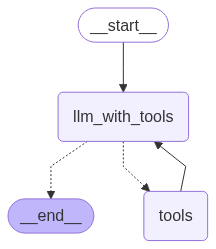

In [18]:
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(MessagesState)
workflow.add_node("llm_with_tools", call_llm_with_tool_bind)
workflow.add_node("tools", ToolNode(tools))
workflow.add_edge(START, "llm_with_tools")
workflow.add_conditional_edges("llm_with_tools", tools_condition)
workflow.add_edge("tools", "llm_with_tools")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

In [22]:
events = app.stream(
    {
        "messages": [HumanMessage(content="""
                                I'm planning a short trip to South Goa next weekend. Can you show me a few 4-star or 5-star hotels around that area for check-in on July 13 and check-out on July 15, 2025?
                                I prefer free cancellation options if available. Include the lat, long of the hotel and the hotel distance from the central location of the south goa. give the website of the hotel with phone number if possible.
                                    """)]
    },
    config={"configurable": {"thread_id": "demo"}},
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()


================================ Human Message =================================


                                I'm planning a short trip to South Goa next weekend. Can you show me a few 4-star or 5-star hotels around that area for check-in on July 13 and check-out on July 15, 2025?
                                I prefer free cancellation options if available. Include the lat, long of the hotel and the hotel distance from the central location of the south goa. give the website of the hotel with phone number if possible.
                                    
================================== Ai Message ==================================
Tool Calls:
  get_hotels_by_area_and_radius (call_bf9F376KS9qtmcnqaHMfsGeL)
 Call ID: call_bf9F376KS9qtmcnqaHMfsGeL
  Args:
    bbox: 15.0583,15.1583,73.7511,73.8511
    arrival_date: 2025-07-13
    departure_date: 2025-07-15
    star_rating: 4,5
================================= Tool Message =================================
Name: get_hotels_by_are

In [20]:
events = app.stream(
    {
        "messages": [HumanMessage(content="""
                                    I'm traveling to Paris this weekend. Give me a details summary of what are attractive places in paris and what need to be my budget for this entire trip including hotel price and flight fares?
                                    I will travelling from Bangalore, on July 12, 2025 and my trip duration expected to be 5 days. 
                                    Give all price break down in INR with details analysis. And what about the current weather there? is this a suitable season as a tourist to do a trip there?
                                    Is there any internal conflicts going on there? as a tourist I'm very much aware on my safety.
                                    It's fine if there are no direct flights available from Bangalore to Paris; however, in that case, please provide a price breakdown analysis for a layover journey.
                                    """)]
    },
    config={"configurable": {"thread_id": "demo"}},
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()


================================ Human Message =================================


                                    I'm traveling to Paris this weekend. Give me a details summary of what are attractive places in paris and what need to be my budget for this entire trip including hotel price and flight fares?
                                    I will travelling from Bangalore, on July 12, 2025 and my trip duration expected to be 5 days. 
                                    Give all price break down in INR with details analysis. And what about the current weather there? is this a suitable season as a tourist to do a trip there?
                                    Is there any internal conflicts going on there? as a tourist I'm very much aware on my safety.
                                    It's fine if there are no direct flights available from Bangalore to Paris; however, in that case, please provide a price breakdown analysis for a layover journey.
                                

In [23]:
events = app.stream(
    {
        "messages": [HumanMessage(content="Suggest me some trekking site near chennai.")]
    },
    config={"configurable": {"thread_id": "demo"}},
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Suggest me some trekking site near chennai.
================================== Ai Message ==================================
Tool Calls:
  get_places (call_0iSNNLiLFXl7BAXE18jLEAnc)
 Call ID: call_0iSNNLiLFXl7BAXE18jLEAnc
  Args:
    city: Chennai
    query: trekking
================================= Tool Message =================================
Name: get_places

[{"message": "No results found for 'trekking' in Chennai."}]
================================== Ai Message ==================================

It seems there are no specific trekking sites listed directly in Chennai. However, here are some popular trekking destinations near Chennai that you might consider:

1. **Yelagiri Hills**
   - **Distance from Chennai:** Approximately 230 km
   - **Trekking Details:** Offers various trekking trails with beautiful views, especially the trek to Swamimalai Hill.

2. **Kudremukh**
   - **Distance from Chennai:

In [24]:
events = app.stream(
    {
        "messages": [HumanMessage(content="Suggest me some 4 & 5 star hotels for two adults near kolkata international airport for 2 days staying from July 12 to July 14, 2025, list the hotels based on the asceding order of distance from the airport. give all the information of hotels like pricing per night, address, phone number, web-site")]
    },
    config={"configurable": {"thread_id": "demo"}},
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Suggest me some 4 & 5 star hotels for two adults near kolkata international airport for 2 days staying from July 12 to July 14, 2025, list the hotels based on the asceding order of distance from the airport. give all the information of hotels like pricing per night, address, phone number, web-site
================================== Ai Message ==================================
Tool Calls:
  get_hotels_by_area_and_radius (call_57d9NBRSiy5H7FiDERKBo5XN)
 Call ID: call_57d9NBRSiy5H7FiDERKBo5XN
  Args:
    bbox: 22.6551,22.7551,88.4271,88.5271
    arrival_date: 2025-07-12
    departure_date: 2025-07-14
    star_rating: 4,5
================================= Tool Message =================================
Name: get_hotels_by_area_and_radius

[{"name": "Hotel O GOLDEN NEST", "star_rating": 4.0, "review_score": null, "review_word": "Bad", "review_count": 1, "address": "Plot No. 22/3, Helabot Tola Kroshna Nagar Roa